In [2]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
import os
from os import path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow.keras import layers, models

# Reading the dataset

In [3]:
# Mapping the labels to binary numbers using dictionary
classes = {
    "Harry" : 0,
    "MandarTule" : 1,
}

In [4]:
# Reading the Images from the dataset along with their labels
target_size=(100, 100)
images = []
labels = []

root_dir = "./Dataset"
for subdir, dirs, files in os.walk(root_dir):
    if files:
        label = subdir.split('\\')[1]
        for file in files:
            img = cv2.imread(os.path.join(subdir, file))
            images.append(img)
            labels.append(classes[label])
            
images[1], labels[1]

(array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [5]:
images[2], labels[1]

(array([[[255, 254, 255],
         [255, 254, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 254, 255],
         [255, 254, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 254, 255],
         [255, 254, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [6]:
# Resizing the images and converting to numpy array
def resize(image):
    target_size=(100, 100)
    resized_image = cv2.resize(image, target_size)
    return resized_image

resized_images = []
for image in images:
    resized_images.append(resize(image))
images_array = np.array(resized_images)
images_array.shape

(469, 100, 100, 3)

# PreProcessing

In [7]:
def conversion_grayscale(image):
#      If image is coloured, convert to gray scale
    if image.shape[-1] >=2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
#         plt.imshow(image) 
    return image
img = conversion_grayscale(images_array[1])

In [8]:
def noise_reduction(image):
    img = cv2.blur(image, (5, 5))
    imgBlurred = cv2.GaussianBlur(img, (11, 11), 5)  # blur
#     plt.imshow(imgBlurred)
    return img

img = noise_reduction(img)

In [9]:
def get_corpus_boundaries(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    min_vertical = float('inf')
    max_vertical = 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        min_vertical = min(min_vertical, y)
        max_vertical = max(max_vertical, y + h)
    
    return min_vertical, max_vertical

In [10]:
def extract_text_region(image):
    _, img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Vertical crop to extract text region
    min_vertical, max_vertical = get_corpus_boundaries(img)
    img = img[min_vertical:max_vertical]
    
#     plt.plot(img)
    
    return img

img = extract_text_region(img)

In [11]:
def extract_characters(img):
    # Binarize the image using Otsu's thresholding
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Apply morphological operations to remove noise and connect nearby characters
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    # Find contours of individual characters
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Extract individual characters based on contours
    characters = []
    for contour in contours:
        # Get bounding box of contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Extract individual character by slicing
        character = img[y:y+h, x:x+w]
        
        # Add character to the list
        characters.append(character)
    
    return characters

characters = extract_characters(img)
characters

[array([[  0, 255, 255, ...,   0,   0,   0],
        [  0, 255, 255, ...,   0,   0,   0],
        [  0,   0, 255, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ..., 255,   0,   0],
        [  0,   0,   0, ..., 255,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)]

In [12]:
def extract_texture(image):

    lbp = local_binary_pattern(image, 8, 1, method='uniform')
    
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
    
    return hist

def texture_features(characters):
    character_texture_features = []

    # Iterate through each character and perform texture extraction
    for character in characters:
        # Perform texture extraction on the character
        texture_features = extract_texture(character)

        # Append the texture features to the list
        character_texture_features.append(texture_features)
    return character_texture_features

Preprocessed_Image = texture_features(characters)
Preprocessed_Image

[array([   2,   63,    0,  329,    0, 1012,    0,  239, 8355], dtype=int64)]

In [13]:
def preprocess(image):
    image = conversion_grayscale(image)
    image = noise_reduction(image)
    image = extract_text_region(image)
    characters = extract_characters(image)
    Preprocessed_Image = texture_features(characters)
    
    return Preprocessed_Image

# Label Extraction

In [14]:
X = []
y = []

for image, label in zip(images_array, labels):
    Preprocessed_Image = preprocess(image)
    
    Preprocessed_Image = preprocess(image)
    X = X + Preprocessed_Image
    new_arr = [label for i in range(len(Preprocessed_Image))]
    y = y + new_arr


In [15]:
X

[array([   2,   53,    0,  325,    0, 1108,    0,  272, 8240], dtype=int64),
 array([   2,   63,    0,  329,    0, 1012,    0,  239, 8355], dtype=int64),
 array([   1,   41,    0,  281,    0, 1170,    0,  176, 8331], dtype=int64),
 array([ 0,  5,  0,  0,  0,  0,  0,  0, 55], dtype=int64),
 array([0, 2, 0, 0, 0, 0, 0, 0, 7], dtype=int64),
 array([   4,   63,    0,  289,    0, 1169,    0,  247, 7928], dtype=int64),
 array([   0,   47,    0,  271,    0, 1289,    0,  209, 8184], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int64),
 array([   0,   23,    0,  221,    0,  843,    0,  151, 8362], dtype=int64),
 array([   0,   11,    0,   74,    0,  529,    0,   31, 4055], dtype=int64),
 array([1, 0, 0, 0, 0, 0, 0, 0, 9], dtype=int64),
 array([1, 0, 0, 0, 0, 0, 0, 0, 9], dtype=int64),
 array([ 0,  2,  0,  0,  0,  0,  0,  0, 13], dtype=int64),
 array([   4,   30,    0,  171,    0,  786,    0,  143, 4466], dtype=int64),
 array([   1,   57,    0,  294,    0,  997,    0,  152, 8499], dty

# Model Building

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=1, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,  random_state=42, shuffle=True)

# len(X_train), len(y_train)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_val = np.array(X_val)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

type(X_train)

numpy.ndarray

## Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Example input shape
input_shape = (X_train[0], X_train[1])  # Example input shape (height, width)
num_classes = 2  # Example number of classes

# Reshape the input data to 1D array
# X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
# X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Create the Random Forest Classifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
train_accuracy = rf_model.score(X_train, y_train)
test_accuracy = rf_model.score(X_test, y_test)
print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)



Train accuracy: 0.9357638888888888
Test accuracy: 0.844559585492228


In [18]:
def predict(path, model):
    img = cv2.imread(path)
    if img is None:
        print("Not found")
        return
    plt.imshow(img)
    resized_images = cv2.resize(img, target_size)
    resized_images = np.array(resized_images)
    Preprocessed_Image = preprocess(resized_images)
    
    return np.argmax(model.predict(Preprocessed_Image))

0

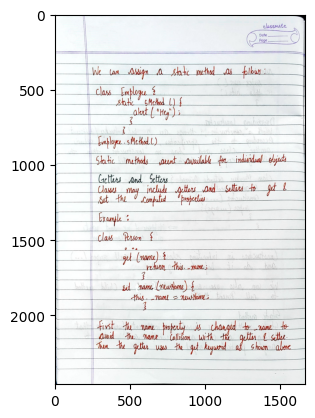

In [19]:
predict("./Test_Images/Harry_04.jpg", rf_model)

## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = lr_model.predict(X_test)

# Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

train_accuracy = lr_model.score(X_train, y_train)
test_accuracy = lr_model.score(X_test, y_test)
print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

Accuracy: 0.8497409326424871
Train accuracy: 0.8142361111111112
Test accuracy: 0.8497409326424871


# Data Augmentation

It seems like the data is underfitted. Let's perform some data augmentation to increase the size of dataset.

In [21]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np

# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
def augmentation(folder, filename, destination):
    image = Image.open(os.path.join(folder,filename))
    Image_array = np.array(image)

    # Reshape the image array to (1, height, width, channels) to fit Keras' requirements
    Image_array = Image_array.reshape((1,) + Image_array.shape)

    # Generate augmented images
    augmented_images = []
    for batch in datagen.flow(Image_array, batch_size=1, save_to_dir=f'./Dataset_Augmented/{destination}/', save_prefix='aug', save_format='jpg'):
        augmented_images.append(batch[0])
        if len(augmented_images) >= 2:  # Generate 5 augmented images
            break

# Display or save the augmented images as needed
augmentation("./Dataset/Harry/", "C_Complete_Notes-02.jpg", "Harry")

In [22]:
First_Category = "Harry"
folder = f'./Dataset/{First_Category}'
for filename in os.listdir(f"./Dataset/{First_Category}/"):
    augmentation(folder, filename, First_Category)

In [23]:
Second_Category = "MandarTule"
folder = f'./Dataset/{Second_Category}'
for filename in os.listdir(f"./Dataset/{Second_Category}/"):
    augmentation(folder, filename, Second_Category)

In [22]:
# Reading the Images from the dataset along with their labels
target_size=(100, 100)
images2 = []
labels2 = []

root_dir = "./Dataset_Augmented"
for subdir, dirs, files in os.walk(root_dir):
    if files:
        label = subdir.split('\\')[1]
        for file in files:
            img = cv2.imread(os.path.join(subdir, file))
            images2.append(img)
            labels2.append(classes[label])
            
images2[2], labels2[1]

(array([[[215, 215, 215],
         [215, 215, 215],
         [215, 215, 215],
         ...,
         [  2,   4,   4],
         [  2,   4,   4],
         [  2,   4,   4]],
 
        [[217, 217, 217],
         [217, 217, 217],
         [216, 216, 216],
         ...,
         [  2,   4,   4],
         [  2,   4,   4],
         [  2,   4,   4]],
 
        [[220, 220, 220],
         [220, 220, 220],
         [219, 219, 219],
         ...,
         [  2,   4,   4],
         [  2,   4,   4],
         [  2,   4,   4]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 56,  84,  95],
         [ 59,  87,  98],
         [ 61,  89, 100]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 51,  79,  90],
         [ 53,  81,  92],
         [ 54,  82,  93]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 46,  72,  84],
  

In [23]:
def resize(image):
    target_size=(100, 100)
    resized_image = cv2.resize(image, target_size)
    return resized_image

resized_images = []
for image in images2:
    resized_images.append(resize(image))
    
images_array2 = np.array(resized_images)
images_array2.shape

(928, 100, 100, 3)

In [1]:
# X = []
# y = []

for image, label in zip(images_array2, labels2):
    Preprocessed_Image = preprocess(image)
    
    Preprocessed_Image = preprocess(image)
    X = X + Preprocessed_Image
    new_arr = [label for i in range(len(Preprocessed_Image))]
    y = y + new_arr
print(y)

NameError: name 'images_array2' is not defined

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=1, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,  random_state=42, shuffle=True)

# len(X_train), len(y_train)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_val = np.array(X_val)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

type(X_train)

numpy.ndarray

In [26]:
np.unique(y_train)

array([0, 1])

# Running the model on Augmented Dataset

## Random forest Classifier

In [41]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth = 8, min_samples_split = 10, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
train_accuracy = rf_model.score(X_train, y_train)
test_accuracy = rf_model.score(X_test, y_test)
print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

Train accuracy: 0.8754464285714286
Test accuracy: 0.8433734939759037


In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr_model = LogisticRegression(max_iter=1000)  

# Define hyperparameters to tune
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2']  # Penalty type
}

#  Perform hyperparameter tuning using grid search
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model on the test set
best_lr_model = grid_search.best_estimator_
y_pred = best_lr_model.predict(X_test)

# Print classification report (including precision, recall, F1-score, etc.)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Hyperparameters: {'C': 0.001, 'penalty': 'l2'}
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       580
           1       0.65      0.39      0.49       167

    accuracy                           0.82       747
   macro avg       0.75      0.66      0.69       747
weighted avg       0.80      0.82      0.80       747



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\li

In [49]:
lr_model = LogisticRegression(C=0.001, penalty='l2', max_iter=1000)

# Train the logistic regression model on the training data
lr_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = lr_model.predict(X_test)

train_accuracy = lr_model.score(X_train, y_train)
test_accuracy = lr_model.score(X_test, y_test)
print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

Train accuracy: 0.80625
Test accuracy: 0.8165997322623829


In [42]:
import pickle

# Save the trained model to a file
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

In [50]:
import pickle

# Save the trained model to a file
with open('linear_classification_model.pkl', 'wb') as file:
    pickle.dump(lr_model, file)